In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
import numpy as np
from pandas import DataFrame
import pandas as pd
import re
from notebook_utils import NotebookUtilities
from datetime import timedelta
import matplotlib.pyplot as plt
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs out of one DataFrame
if nu.pickle_exists('clean_csvs_df'):
    clean_csvs_df = nu.load_object('clean_csvs_df')
    print(clean_csvs_df.shape)
    df = clean_csvs_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(149166, 101)


,131748,62328,21067,50204
action_type,S_A_L_T_WALK_IF_CAN,TOOL_HOVER,TOOL_HOVER,TOOL_HOVER
elapsed_time,25290,505274,6068769,376895
event_time,2023-04-21 09:41:00,2023-06-23 10:32:00,2023-05-16 17:56:00,2023-03-03 13:52:00
session_uuid,f68ce2b4-67dc-4829-89fc-cfe478391148,3459b742-650d-4c82-bb7b-db84a843cc66,724fdf45-3165-43b8-b9ca-dc07102d2886,e2e599c8-8e48-487f-9f95-a0a382432ca5
file_name,max11,3459b742-650d-4c82-bb7b-db84a843cc66,724fdf45-3165-43b8-b9ca-dc07102d2886,Marty9
time_group,1,2,14,2
s_a_l_t_walk_if_can_sort_location,"(2.6, 0.0, -1.4)",NaN,NaN,NaN
s_a_l_t_walk_if_can_sort_command_text,walkIfCan,NaN,NaN,NaN
s_a_l_t_walk_if_can_patient_id,Mike_0 Root,NaN,NaN,NaN
tool_hover_type,NaN,Needle,Gauze,Hemostatic Gauze


In [4]:

def get_session_groupby(mask_series=None, extra_column=None):
    if (mask_series is None) and (extra_column is None):
        gb = clean_csvs_df.sort_values(['elapsed_time']).groupby(['session_uuid'])
    elif (mask_series is None) and (extra_column is not None):
        gb = clean_csvs_df.sort_values(['elapsed_time']).groupby(['session_uuid', extra_column])
    elif (mask_series is not None) and (extra_column is None):
        gb = clean_csvs_df[mask_series].sort_values(['elapsed_time']).groupby(['session_uuid'])
    elif (mask_series is not None) and (extra_column is not None):
        gb = clean_csvs_df[mask_series].sort_values(['elapsed_time']).groupby(['session_uuid', extra_column])

    return gb

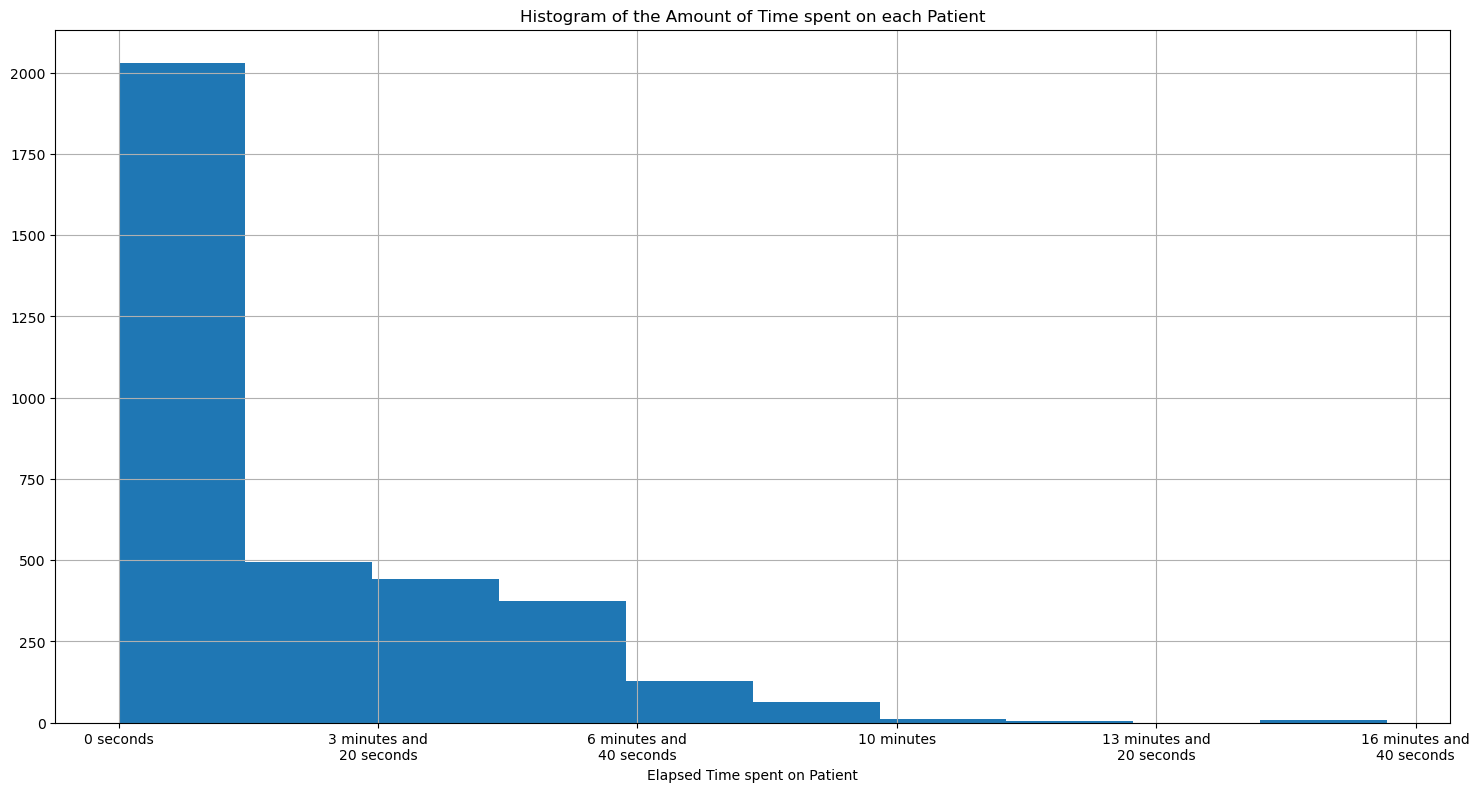

In [7]:

from matplotlib.text import Text
import humanize
from datetime import timedelta

rows_list = []

# Get all SESSION_START and _END periods
for (session_uuid, time_group), df1 in get_session_groupby(
	mask_series=None, extra_column='time_group'
):
	
    # Get all patients in that period
    for patient_id, df2 in df1.groupby('patient_id'):
        row_dict = {}
        row_dict['session_uuid'] = session_uuid
        row_dict['time_group'] = time_group
        row_dict['patient_id'] = patient_id
        
        # Get the timeline for patient engagement
        xmin = df2.elapsed_time.min(); row_dict['engagement_start'] = xmin
        xmax = df2.elapsed_time.max(); row_dict['engagement_stop'] = xmax
        engagement_delta = xmax - xmin; row_dict['engagement_delta'] = engagement_delta
        rows_list.append(row_dict)

engagement_delta_df = DataFrame(rows_list)
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
engagement_delta_df.engagement_delta.hist(ax=ax)

# Set the title and labels
ax.set_title(f'Histogram of the Amount of Time spent on each Patient')
ax.set_xlabel('Elapsed Time spent on Patient')

# tick_locations = ax.get_xticks()
# print(tick_locations)

tick_labels = ax.get_xticklabels()
# print(tick_labels)

ax.set_xticklabels([
    Text(-200000.0, 0, ''), Text(0.0, 0, '0 seconds'),
    Text(200000.0, 0, humanize.precisedelta(timedelta(milliseconds=200000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(400000.0, 0, humanize.precisedelta(timedelta(milliseconds=400000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(600000.0, 0, humanize.precisedelta(timedelta(milliseconds=600000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(800000.0, 0, humanize.precisedelta(timedelta(milliseconds=800000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(1000000.0, 0, humanize.precisedelta(timedelta(milliseconds=1000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(1200000.0, 0, '')
]);

In [28]:

# Get all SESSION_START and _END periods
for (session_uuid, time_group), df1 in get_session_groupby(
	mask_series=None, extra_column='time_group'
):
	
    # Get all patients in that period
    for patient_id, df2 in df1.groupby('patient_id'):
        row_dict = {}
        row_dict['session_uuid'] = session_uuid
        row_dict['time_group'] = time_group
        row_dict['patient_id'] = patient_id
        
        # Get the timeline for patient engagement
        mask_series = df2.action_type.isin(['INJURY_RECORD', 'PATIENT_RECORD'])
        xmin = df2[~mask_series].elapsed_time.min(); row_dict['engagement_start'] = xmin
        xmax = df2.elapsed_time.max(); row_dict['engagement_stop'] = xmax
        engagement_delta = xmax - xmin; row_dict['engagement_delta'] = engagement_delta
        rows_list.append(row_dict)

engagement_delta_df = DataFrame(rows_list)

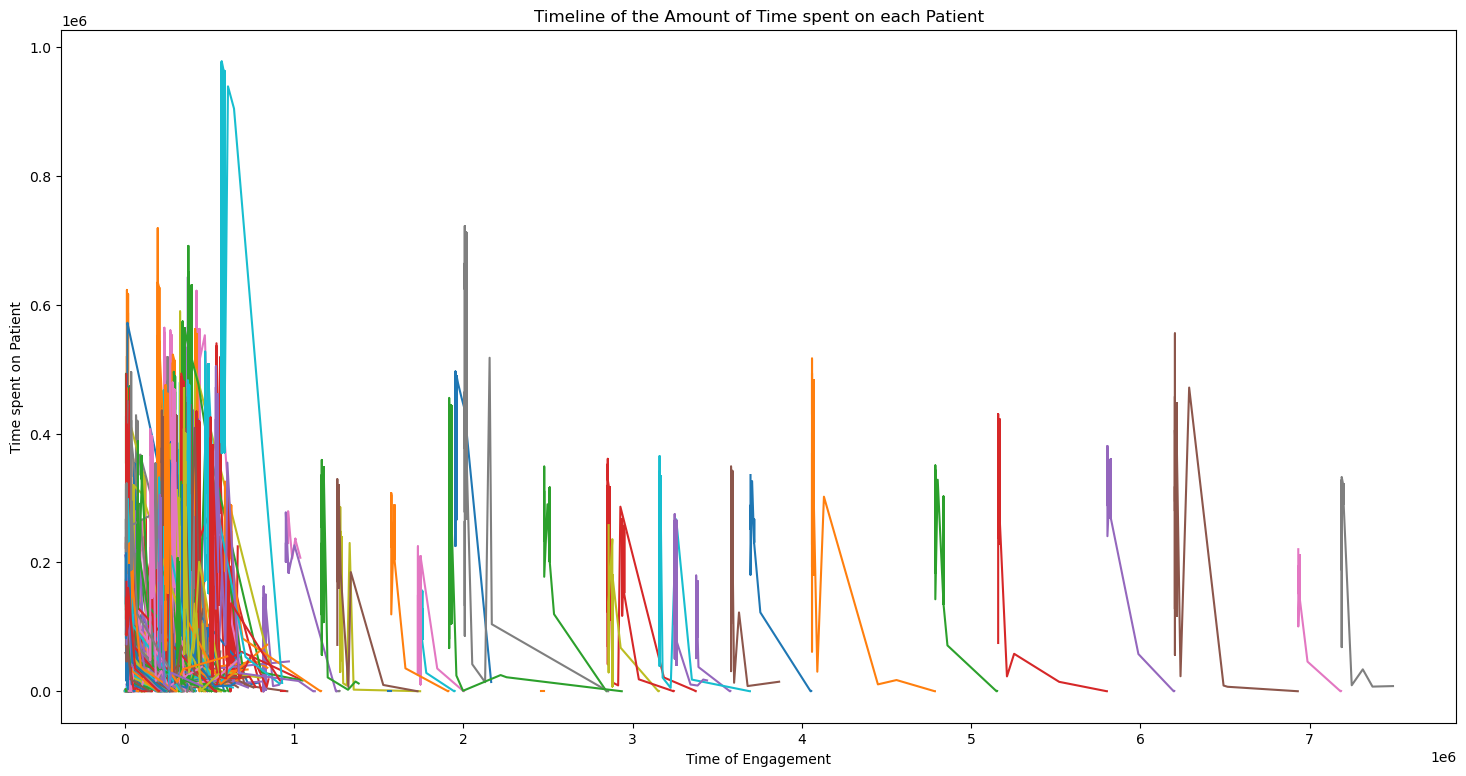

In [26]:

# Add all time groups as line plots of engagement start vs delta
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
for (session_uuid, time_group), df in engagement_delta_df.groupby(['session_uuid', 'time_group']):
    df.sort_values('engagement_start').plot(x='engagement_start', y='engagement_delta', kind='line', ax=ax, label=None)

# Set the title and labels
ax.set_title('Timeline of the Amount of Time spent on each Patient')
ax.set_xlabel('Time of Engagement')
ax.set_ylabel('Time spent on Patient')
legend = plt.legend(loc=None)
legend.set_visible(False);

In [65]:

srs = clean_csvs_df.groupby(['session_uuid', 'time_group']).patient_id.unique().map(lambda x: len(x)).value_counts().sort_index()
mask_series = (srs > 1)
max_ranking = srs[mask_series].tail(1).index.tolist()[0]

In [77]:

import pandas as pd

columns_list = ['patient_ranking', 'engagement_start', 'engagement_delta']
patient_ranking_df = DataFrame([], columns=columns_list)
for (session_uuid, time_group), df in engagement_delta_df.groupby(['session_uuid', 'time_group']):
    offset = df.engagement_start.min()
    df.engagement_start = df.engagement_start - offset
    columns_list = ['index', 'engagement_start', 'engagement_delta']
    df = df.drop_duplicates(
        subset=['engagement_start', 'engagement_delta']
    ).sort_values('engagement_start').reset_index(drop=True).reset_index(drop=False)[columns_list].rename(
        columns={'index': 'patient_ranking'}
    ).iloc[:max_ranking]
    group_max_ranking = df.patient_ranking.max()
    if group_max_ranking > (max_ranking + 1): raise
    patient_ranking_df = pd.concat([patient_ranking_df, df], axis='index')

In [81]:

?

Signature: humanize.ordinal(value: 'NumberOrString', gender: 'str' = 'male') -> 'str'
Docstring:
Converts an integer to its ordinal as a string.

For example, 1 is "1st", 2 is "2nd", 3 is "3rd", etc. Works for any integer or
anything `int()` will turn into an integer. Anything else will return the output
of str(value).

Examples:
    ```pycon
    >>> ordinal(1)
    '1st'
    >>> ordinal(1002)
    '1002nd'
    >>> ordinal(103)
    '103rd'
    >>> ordinal(4)
    '4th'
    >>> ordinal(12)
    '12th'
    >>> ordinal(101)
    '101st'
    >>> ordinal(111)
    '111th'
    >>> ordinal("something else")
    'something else'
    >>> ordinal([1, 2, 3]) == "[1, 2, 3]"
    True

    ```
Args:
    value (int, str, float): Integer to convert.
    gender (str): Gender for translations. Accepts either "male" or "female".

Returns:
    str: Ordinal string.
File:      c:\users\davebabbitt\documents\github\notebooks\nb_env\lib\site-packages\humanize\number.py
Type:      function


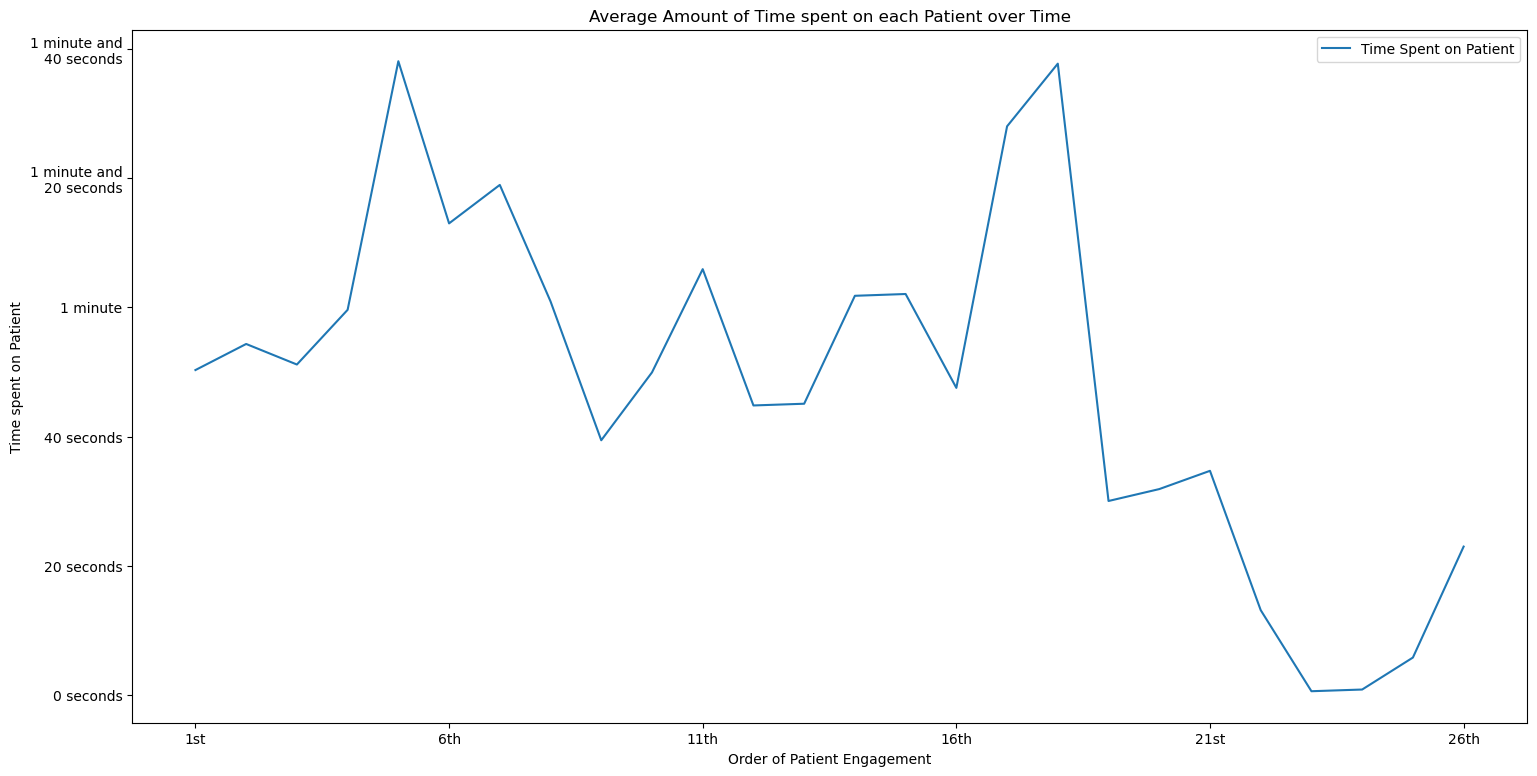

In [84]:

ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
patient_ranking_df.dropna(axis='index', how='any').groupby('patient_ranking').mean().reset_index(drop=False).plot(
    x='patient_ranking', y='engagement_delta', kind='line', label='Time Spent on Patient', ax=ax
)
ax.set_title('Average Amount of Time spent on each Patient over Time')
ax.set_xlabel('Order of Patient Engagement')
ax.set_ylabel('Time spent on Patient')
ax.set_yticklabels([
    Text(-20_000.0, 0, ''), Text(0.0, 0, '0 seconds'),
    Text(20_000.0, 0, humanize.precisedelta(timedelta(milliseconds=20_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(40_000.0, 0, humanize.precisedelta(timedelta(milliseconds=40_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(60_000.0, 0, humanize.precisedelta(timedelta(milliseconds=60_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(80_000.0, 0, humanize.precisedelta(timedelta(milliseconds=80_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(100_000.0, 0, humanize.precisedelta(timedelta(milliseconds=100_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(120_000.0, 0, humanize.precisedelta(timedelta(milliseconds=120_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(140_000.0, 0, humanize.precisedelta(timedelta(milliseconds=140_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(160_000.0, 0, humanize.precisedelta(timedelta(milliseconds=160_000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(180_000.0, 0, '')
])
# print(ax.get_xticklabels())
ax.set_xticklabels([
    Text(-5.0, 0, ''),
    Text(0.0, 0, humanize.ordinal(0.0+1)),
    Text(5.0, 0, humanize.ordinal(5.0+1)),
    Text(10.0, 0, humanize.ordinal(10.0+1)),
    Text(15.0, 0, humanize.ordinal(15.0+1)),
    Text(20.0, 0, humanize.ordinal(20.0+1)),
    Text(25.0, 0, humanize.ordinal(25.0+1)),
    Text(30.0, 0, '')
]);

In [51]:

clean_csvs_df.groupby(['session_uuid', 'time_group', 'patient_id']).size()

session_uuid                          time_group  patient_id   
04882754-51a0-4e5b-9617-b200e3609116  0           Mike_1 Root       1
                                                  Mike_2 Root       1
                                                  Mike_3 Root       1
                                      1           Bob_0 Root        2
                                                  Gary_1 Root       1
                                                                   ..
ff97fc56-c803-4aa7-b419-35e0ac17d0b3  2           Helga_10 Root    15
                                                  Lily_2 Root      15
                                                  Lily_4 Root      19
                                                  Mike_5 Root      20
                                                  Mike_7 Root      17
Length: 3558, dtype: int64